# TP5 : Clustering

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples, adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

Version des librairies utilisées pour coder ce notebook :
- pandas version: 1.1.4
- numpy version: 1.19.4
- matplotlib version: 3.3.3
- scikit-learn version: 0.23.2

In [ ]:
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("matplotlib version:", matplotlib.__version__)
print("scikit-learn version:", sklearn.__version__)

pandas version: 1.1.4
numpy version: 1.18.5
matplotlib version: 3.2.2
scikit-learn version: 0.22.2.post1


Dans ce notebook nous allons appliquer des algorithmes de clustering à différent jeux de données. Dans un premier temps nous manipulerons ces algorithmes sur des données simulées simples, afin d'explorer leur paramètres. Nous allons ensuite introduire quelques concepts pour évaluer la qualité d'un cluster. Une dernière partie sera l'occasion de clusteriser une population de pingouins parmi trois espèces.

# 0 - Préparation données

Nous utilisons **5 jeux de données** (4 simulés et 1 réel). Chacune des bases sera accessible via un dataframe qui regroupera ses features (*x1*, *x2*, etc.) ainsi que les vrais clusters (*label*) ou les clusters prédits (*cluster*).

## Fonction plot

In [ ]:
def plot_point_clouds(data, feature_x, feature_y, feature_label, 
                      title=None, legend=False, figsize=(5, 5)):
    """Plot point clouds.
    
    Parameters
    ----------
    data : pd.DataFrame
        Dataframe with the point cloud values.
    feature_x : str
        Name of the feature to plot along the x-axis.
    feature_y : str
        Name of the feature to plot along the y-axis.
    feature_label : str
        Name of the feature to use to colorized the different clusters.
    title : str
        Title of the plot.
    legend : bool
        Display a legend or not.
    figsize : Tuple
        Tuple with two integers to set the plot size.
    
    """
    # get label names
    labels = list(set(data.loc[:, feature_label]))
    n = len(labels)
    
    # initialize plot
    plt.figure(figsize=figsize)
    
    # scatter plot for each label
    for i, label in enumerate(labels):
        data_label = data.loc[data.loc[:, feature_label] == label]
        x = data_label.loc[:, feature_x]
        y = data_label.loc[:, feature_y]
        if label == -1:
            plt.scatter(x, y, s=30, color="black", label=label)
        else:
            plt.scatter(x, y, s=30, cmap="Paired", label=label)
        
    # format axes and legend
    plt.xlabel(feature_x, fontweight="bold", fontsize=15)
    plt.ylabel(feature_y, fontweight="bold", fontsize=15)
    if title is not None:
        plt.title(title, fontweight="bold", fontsize=20)
    if legend:
        plt.legend(prop={'size': 15})
    plt.tight_layout()
    
    # end plot
    plt.show()
    plt.close()

## Données réelles - Palmer Penguins

La base de donnée réelle que nous utilison a été originellement publiée dans :

  - Gorman KB, Williams TD, Fraser WR (2014). Ecological sexual
    dimorphism and environmental variability within a community of
    Antarctic penguins (genus *Pygoscelis*). PLoS ONE 9(3):e90081.
    <https://doi.org/10.1371/journal.pone.0090081>
    
Les données peuvent être retrouvées sur https://github.com/allisonhorst/palmerpenguins. Pour la suite du notebook nous ne gardons qu'une version simplifiée de la base de données. Cette dernière contient les mensurations et les caractéristiques d'une **population de 344 pingouins issus de 3 espèces différentes** : Chinstrap, Gentoo et Adélie.

![](images/penguins.png "Artwork by @allison_horst")

En local vous pouvez lire les données directement depuis le fichier csv.

In [ ]:
# path = "./data_penguin.csv"
# df_penguin = pd.read_csv(path)
# print(df_penguin.shape)
# print(set(df_penguin.loc[:, "label"]))
# df_penguin.head()

En ligne sur un colab vous pouvez lire la base de données via le package dédié (après avoir utilisé la commande *!pip install palmerpenguins*).

In [ ]:
# !pip install palmerpenguins
from palmerpenguins import load_penguins
df_penguin = load_penguins()
df_penguin.loc[:, "label"] = df_penguin.loc[:, "species"].str.lower()
print(df_penguin.shape)
print(set(df_penguin.loc[:, "label"]))
df_penguin.head()

(344, 9)
{'gentoo', 'chinstrap', 'adelie'}


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year,label
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007,adelie
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007,adelie
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007,adelie
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007,adelie
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007,adelie


Parmi les features disponibles nous avons les mensurations du bec, des palmes, le poids et le sexe.
<img src="images/bill_size.png" width="600">

La fonction `plot_point_clouds` permet d'afficher rapidement un nuage de point coloré en fonction du paramètre *feature_label*. 

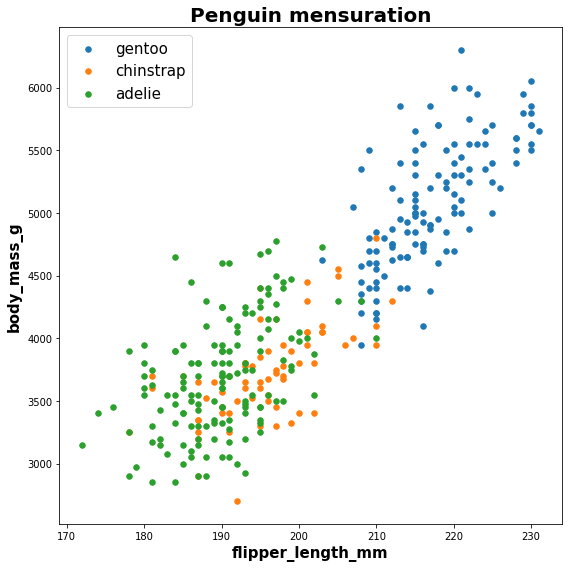

In [ ]:
plot_point_clouds(data=df_penguin, 
                  feature_x="flipper_length_mm", 
                  feature_y="body_mass_g", 
                  feature_label="label",
                  title="Penguin mensuration",
                  legend=True,
                  figsize=(8, 8))

## Données simulées

Nous utilisons également 4 jeux de données simulées qui présentent des caractéristiques bien distinctes :
- Un nuage de points non linéairement séparable en **cercles concentriques**.
- Un nuage de points composé d'un **mélange de gaussiennes** avec des variances différentes.
- Un nuage de point **anisotrope** (la variance va dépendre de la direction).
- Un nuage de point suivant une loi uniforme, **sans structure sous-jacente**.

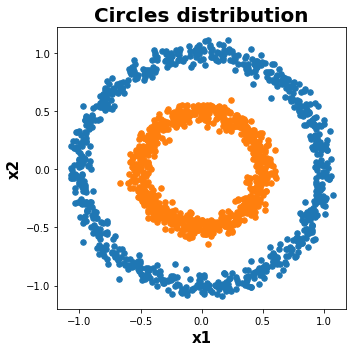

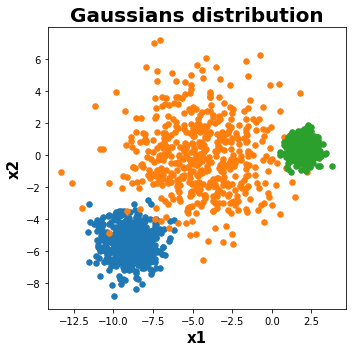

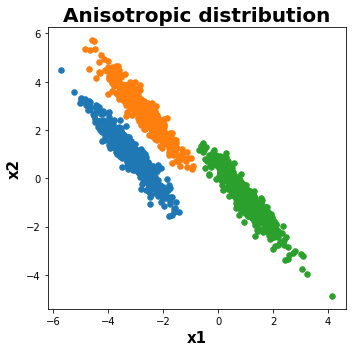

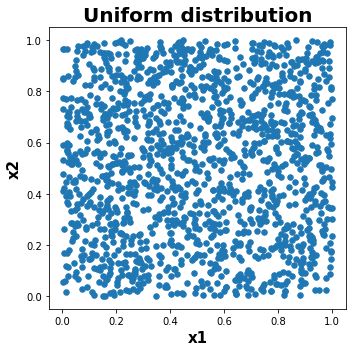

In [ ]:
# parameters
random_state = 170
n_samples = 1500

# set random seed
np.random.seed(random_state)

### Circles ###
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
df_circles = pd.DataFrame({"x1": noisy_circles[0][:, 0],
                           "x2": noisy_circles[0][:, 1],
                           "label": noisy_circles[1]})
plot_point_clouds(data=df_circles, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="label",
                  title="Circles distribution")

### Blobs distribution ###
data, label = datasets.make_blobs(n_samples=n_samples, 
                                  cluster_std=[1.0, 2.5, 0.5], 
                                  random_state=random_state)
df_blobs = pd.DataFrame({"x1": data[:, 0],
                         "x2": data[:, 1],
                         "label": label})
plot_point_clouds(data=df_blobs, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="label",
                  title="Gaussians distribution")

### Anisotropic distribution ###
data, label = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
data_aniso = np.dot(data, transformation)
df_aniso = pd.DataFrame({"x1": data_aniso[:, 0],
                         "x2": data_aniso[:, 1],
                         "label": label})
plot_point_clouds(data=df_aniso, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="label",
                  title="Anisotropic distribution")

### Uniform distribution ###
uniform = np.random.rand(n_samples, 2)
label = np.zeros((n_samples,), dtype=np.int64)
df_uniform = pd.DataFrame({"x1": uniform[:, 0],
                           "x2": uniform[:, 1],
                           "label": label})
plot_point_clouds(data=df_uniform, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="label",
                  title="Uniform distribution")

# 1 - Modèles

## K-mean clustering

L'objectif de l'algorithme k-means est retrouver $K$ clusters (et leur centroïde $\mu_k$) de manière à **minimiser la variance intra-cluster** :

\begin{align}
V = \sum_{k = 1}^{K} \sum_{x \in C_k} \frac{1}{|C_k|} (\|x - \mu_k\|^2)
\end{align}

Documentation : https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

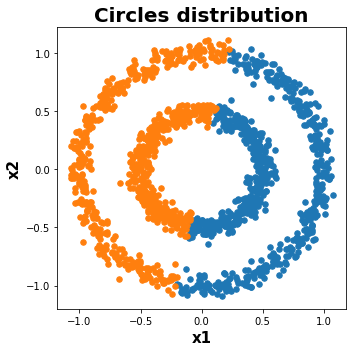

In [ ]:
kmean = KMeans(
    n_clusters=2, init='k-means++', 
    n_init=10, max_iter=300, tol=0.0001, 
    verbose=0, random_state=13, 
    algorithm='auto')
kmean.fit(df_circles.loc[:, ["x1", "x2"]])
df_circles.loc[:, "cluster"] = kmean.labels_
plot_point_clouds(data=df_circles, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Circles distribution")

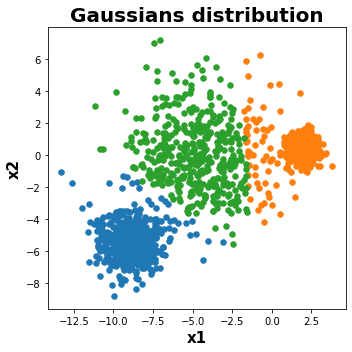

In [ ]:
kmean = KMeans(
    n_clusters=3, init='k-means++', 
    n_init=10, max_iter=300, tol=0.0001, 
    verbose=0, random_state=13, 
    algorithm='auto')
kmean.fit(df_blobs.loc[:, ["x1", "x2"]])
df_blobs.loc[:, "cluster"] = kmean.labels_
plot_point_clouds(data=df_blobs, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Gaussians distribution")

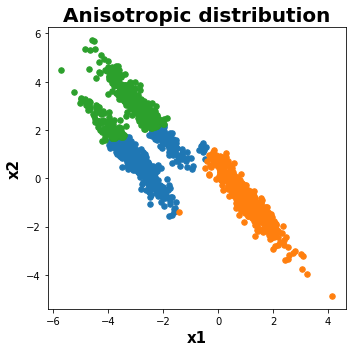

In [ ]:
kmean = KMeans(
    n_clusters=3, init='k-means++', 
    n_init=10, max_iter=300, tol=0.0001, 
    verbose=0, random_state=13,
    algorithm='auto')
kmean.fit(df_aniso.loc[:, ["x1", "x2"]])
df_aniso.loc[:, "cluster"] = kmean.labels_
plot_point_clouds(data=df_aniso, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Anisotropic distribution")

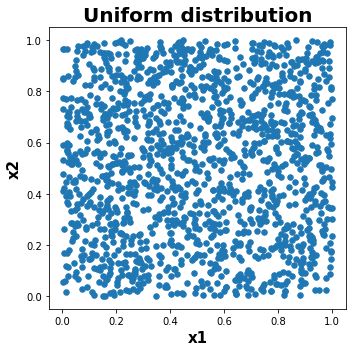

In [ ]:
kmean = KMeans(
    n_clusters=1, init='k-means++', 
    n_init=10, max_iter=300, tol=0.0001, 
    verbose=0, random_state=13, 
    algorithm='auto')
kmean.fit(df_uniform.loc[:, ["x1", "x2"]])
df_uniform.loc[:, "cluster"] = kmean.labels_
plot_point_clouds(data=df_uniform, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Uniform distribution")

**Question :** Après avoir optimisé manuellement les paramètres du k-means, dans quelles situations renvoie-t-il des clusters pertinents ? Dans quels cas est-ce un échec ? Pour quelle raison ?

**Réponse : Les cercles ne sont pas convexe, et car algo k-means est basé sur la distance, la distribution anisotropic ne peut pas être bien regroupé**

## DBSCAN

L'algorithme DBSCAN (Density-Based Spatial Clustering of Applications with Noise) fonctionne en deux temps :
- Toutes les observations suffisamment proches sont connectées entre elles.
- Les observations avec un nombre minimal de voisins connectés sont considérées comme des *core samples*, à partir desquelles les clusters sont étendues. **Toutes les observations suffisamment proche d'un *core sample* appartiennent au même cluster que celui-ci**. 

Documentation : https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

**Code :** Complétez les cellules pour le DBSCAN ci-dessous.

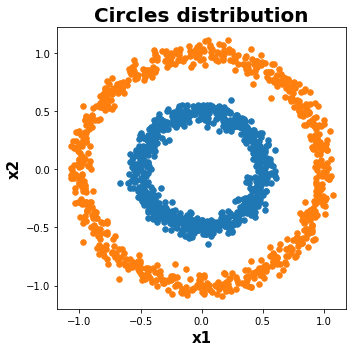

In [ ]:
dbscan = DBSCAN(eps=0.2, min_samples=5, metric='euclidean', 
                 metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
dbscan.fit(df_circles.loc[:, ["x1", "x2"]])
df_circles.loc[:, "cluster"] = dbscan.labels_
plot_point_clouds(data=df_circles, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Circles distribution")

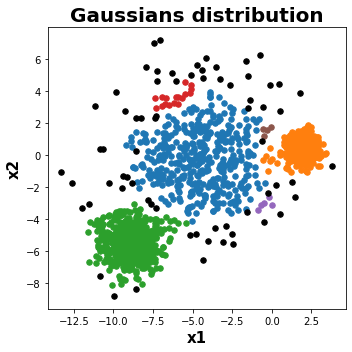

In [ ]:
dbscan = DBSCAN(eps=0.6, min_samples=5, metric='euclidean', 
                 metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
dbscan.fit(df_blobs.loc[:, ["x1", "x2"]])
df_blobs.loc[:, "cluster"] = dbscan.labels_
plot_point_clouds(data=df_blobs, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Gaussians distribution")

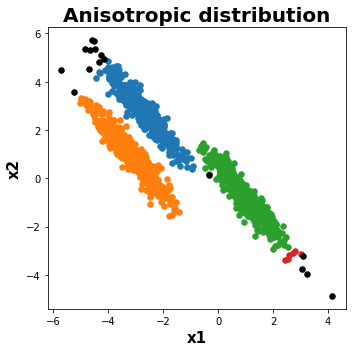

In [ ]:
dbscan = DBSCAN(eps=0.3, min_samples=5, metric='euclidean', 
                 metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
dbscan.fit(df_aniso.loc[:, ["x1", "x2"]])
df_aniso.loc[:, "cluster"] = dbscan.labels_
plot_point_clouds(data=df_aniso, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Anisotropic distribution")

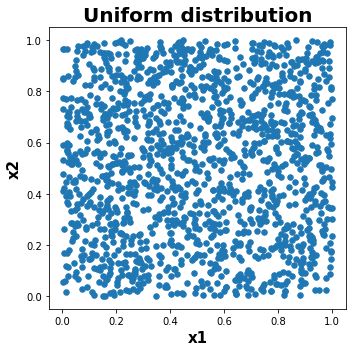

In [ ]:
dbscan = DBSCAN(eps=2, min_samples=2, metric='euclidean', 
                 metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
dbscan.fit(df_uniform.loc[:, ["x1", "x2"]])
df_uniform.loc[:, "cluster"] = dbscan.labels_
plot_point_clouds(data=df_uniform, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Uniform distribution")

**Question :** Après avoir optimisé manuellement les paramètres du DBSCAN, dans quelles situations renvoie-t-il des clusters pertinents ? Dans quels cas est-ce un échec ? Pour quelle raison ? 

**Réponse : quand il n'y a pas assez de voisins autour d'un point, il n'est pas groupé.** 

## Spectral clustering

Le clustering spectral consiste à :
- construire une **matrice d'affinité des observations** en appliquant un kernel ou un algorithme des k plus proches voisins
- construire une **matrice laplacienne normalisée** à partir de la matrice d'affinité
- projeter la matrice laplacienne dans un **espace de plus faible dimension en utilisant son spectre** (ses vecteurs propres)
- **clusteriser** cet espace

L'avantage de cette méthode est de pouvoir retrouver des clusters avec une structure non convexes. La construction de la matrice d'affinité permet également une grande flexibilité et de raisonner sur des graphes.

Documentation : https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html

/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


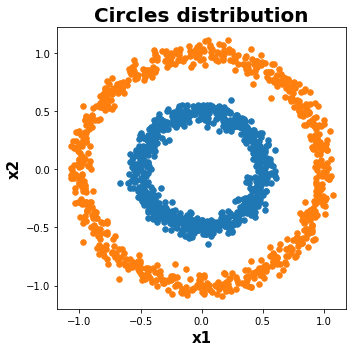

In [ ]:
spectral = SpectralClustering(
    n_clusters=2, random_state=13, 
    n_init=10, gamma=1.0, affinity='nearest_neighbors', n_neighbors=8)
spectral.fit(df_circles.loc[:, ["x1", "x2"]])
df_circles.loc[:, "cluster"] = spectral.labels_
plot_point_clouds(data=df_circles, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Circles distribution")

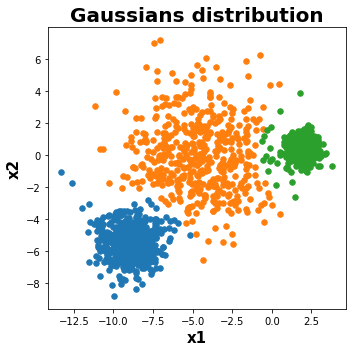

In [ ]:
spectral = SpectralClustering(
    n_clusters=3, random_state=13, 
    n_init=10, gamma=1.0, affinity='rbf', n_neighbors=10)
spectral.fit(df_blobs.loc[:, ["x1", "x2"]])
df_blobs.loc[:, "cluster"] = spectral.labels_
plot_point_clouds(data=df_blobs, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Gaussians distribution")

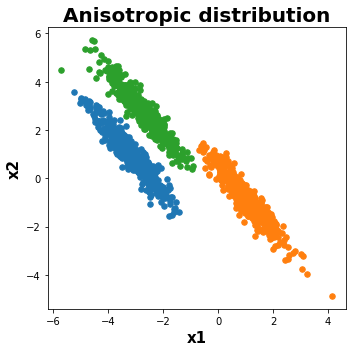

In [ ]:
spectral = SpectralClustering(
    n_clusters=3, random_state=13, 
    n_init=10, gamma=1.0, affinity='nearest_neighbors', n_neighbors=15)
spectral.fit(df_aniso.loc[:, ["x1", "x2"]])
df_aniso.loc[:, "cluster"] = spectral.labels_
plot_point_clouds(data=df_aniso, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Anisotropic distribution")

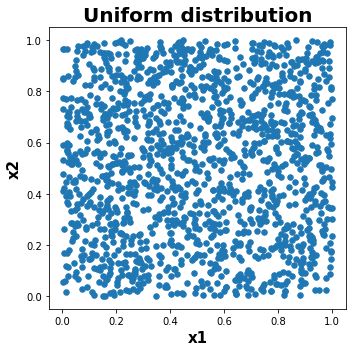

In [ ]:
spectral = SpectralClustering(
    n_clusters=1, random_state=13, 
    n_init=10, gamma=1.0, affinity='nearest_neighbors', n_neighbors=5)
spectral.fit(df_uniform.loc[:, ["x1", "x2"]])
df_uniform.loc[:, "cluster"] = spectral.labels_
plot_point_clouds(data=df_uniform, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Uniform distribution")

**Question :** Après avoir optimisé manuellement les paramètres du spectral clustering, dans quelles situations renvoie-t-il des clusters pertinents ? Dans quels cas est-ce un échec ? Pour quelle raison ? 

**Réponse :** 

## Gaussian mixture model

Le modèle de mélange gaussienne cherche à **optimiser les paramètres d'un nombre fini de gaussiennes** aux données. L'impémentation de scikit-learn utilise un algorithme Expectation-Maximization (EM) pour faire converger le modèle.

Documentation : https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

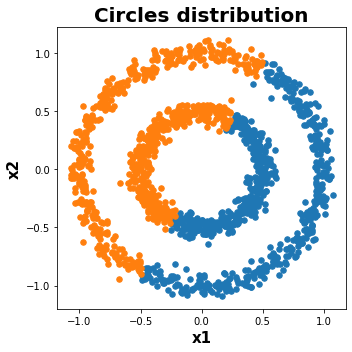

In [ ]:
gmm = GaussianMixture(
    n_components=2, max_iter=100, 
    n_init=1, init_params='kmeans', random_state=13)
gmm.fit(df_circles.loc[:, ["x1", "x2"]])
df_circles.loc[:, "cluster"] = gmm.predict(df_circles.loc[:, ["x1", "x2"]])
plot_point_clouds(data=df_circles, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Circles distribution")

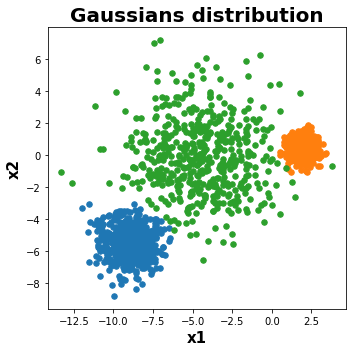

In [ ]:
gmm = GaussianMixture(
    n_components=3, max_iter=100, 
    n_init=1, init_params='kmeans', random_state=13)
gmm.fit(df_blobs.loc[:, ["x1", "x2"]])
df_blobs.loc[:, "cluster"] = gmm.predict(df_blobs.loc[:, ["x1", "x2"]])
plot_point_clouds(data=df_blobs, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Gaussians distribution")

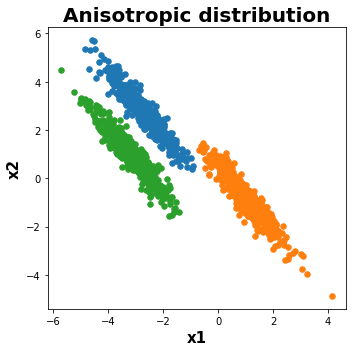

In [ ]:
gmm = GaussianMixture(
    n_components=3, max_iter=100, 
    n_init=1, init_params='kmeans', random_state=13)
gmm.fit(df_aniso.loc[:, ["x1", "x2"]])
df_aniso.loc[:, "cluster"] = gmm.predict(df_aniso.loc[:, ["x1", "x2"]])
plot_point_clouds(data=df_aniso, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Anisotropic distribution")

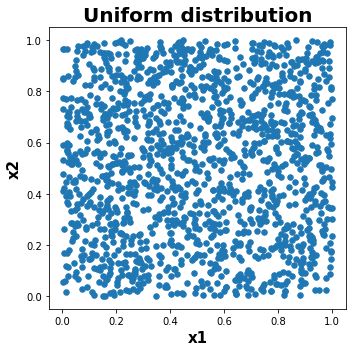

In [ ]:
gmm = GaussianMixture(
    n_components=1, max_iter=100, 
    n_init=1, init_params='kmeans', random_state=13)
gmm.fit(df_uniform.loc[:, ["x1", "x2"]])
df_uniform.loc[:, "cluster"] = gmm.predict(df_uniform.loc[:, ["x1", "x2"]])
plot_point_clouds(data=df_uniform, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Uniform distribution")

**Question :** Après avoir optimisé manuellement les paramètres de la mélange de gaussiennes, dans quelles situations renvoie-t-il des clusters pertinents ? Dans quels cas est-ce un échec ? Pour quelle raison ? 

**Réponse :** 

**Question :** Parmi ces 4 algorithmes de clustering, lequel se distingue des 3 autres au niveau de ses pre-requis ? Pourquoi ?

**Réponse :** 

# 2 - Evaluation des clusters

## Silhouette scores

Le coefficient (ou score) de silhouette permet de **comparer les distances moyennes intra- et inter-cluster** :

\begin{align}
\text{score} = \frac{b - a}{\max(a, b)}
\end{align}

avec $a$ la distance moyenne intra-cluster et $b$ la distance d'un point au cluster étranger le plus proche. Le score se calcule par observation (avec une valeur entre -1 et 1) puis la moyenne de ce score permet d'évaluer le clustering du nuage de point dans son ensemble.

Documentation : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score

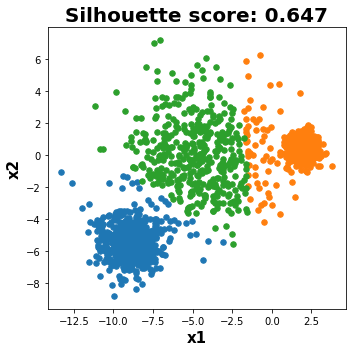

In [ ]:
# clustering
kmean = KMeans(
    n_clusters=3, init='k-means++', 
    n_init=10, max_iter=300, tol=0.0001, 
    verbose=0, random_state=13, 
    algorithm='auto')
kmean.fit(df_blobs.loc[:, ["x1", "x2"]])

# update dataframe clusters
df_blobs.loc[:, "cluster"] = kmean.labels_

# compute silhouette score
score = silhouette_score(
    df_blobs.loc[:, ["x1", "x2"]], 
    labels=df_blobs.loc[:, "cluster"], 
    random_state=13)

# plot
plot_point_clouds(data=df_blobs, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Silhouette score: {0:0.3f}".format(score))

**Question :** Pour quel nombre de clusters recherchés le score de silhouette est-il le plus élevé ?

**Réponse :** 

**Code :** En utilisant la distribution anisotrope, calculer le score de silhouette moyen avec les vrais clusters du nuage de point (et non ceux prédits par k-means).

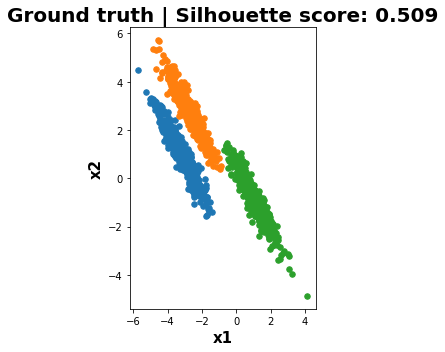

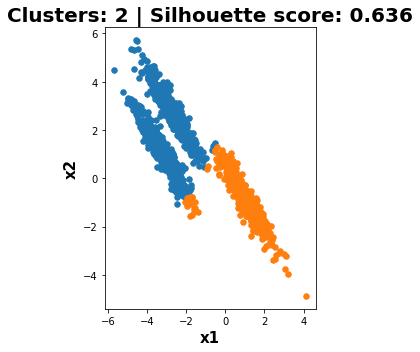

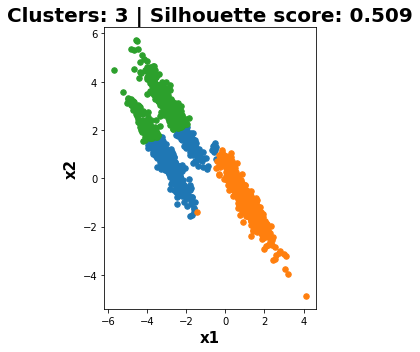

In [ ]:
# score ground truth
score = silhouette_score(
    df_aniso.loc[:, ["x1", "x2"]], 
    labels=df_aniso.loc[:, "cluster"], 
    random_state=13)
title = "Ground truth | Silhouette score: {0:0.3f}".format(score)
plot_point_clouds(data=df_aniso, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="label",
                  title=title)

# score 2 clusters
kmean = KMeans(
    n_clusters=2, init='k-means++', 
    n_init=10, max_iter=300, tol=0.0001, 
    verbose=0, random_state=13, 
    algorithm='auto')

kmean.fit(df_aniso.loc[:, ["x1", "x2"]])

df_aniso.loc[:, "cluster"] = kmean.labels_

score = silhouette_score(
    df_aniso.loc[:, ["x1", "x2"]], 
    labels=df_aniso.loc[:, "cluster"], 
    random_state=13)

title = "Clusters: 2 | Silhouette score: {0:0.3f}".format(score)
plot_point_clouds(data=df_aniso, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title=title)

# score 3 clusters
kmean = KMeans(
    n_clusters=3, init='k-means++', 
    n_init=10, max_iter=300, tol=0.0001, 
    verbose=0, random_state=13, 
    algorithm='auto')

kmean.fit(df_aniso.loc[:, ["x1", "x2"]])

df_aniso.loc[:, "cluster"] = kmean.labels_

score = silhouette_score(
    df_aniso.loc[:, ["x1", "x2"]], 
    labels=df_aniso.loc[:, "cluster"], 
    random_state=13)

title = "Clusters: 3 | Silhouette score: {0:0.3f}".format(score)
plot_point_clouds(data=df_aniso, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title=title)

**Question :** A votre avis, le score de silhouette est-il sensible à la géométrie des clusters (convexité, densité, etc.) ?

**Réponse :** 

## Silhouette plot

En complément du score de silhouette, il est possible d'afficher le score de chaque observation et de **visualiser la *silhouette* des clusters**.

Documentation : https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

**Code :** Adaptez le code ci-dessous pour afficher le graphique de silhouette dans le cadre des données gaussiennes clusterisées avec un k-means.

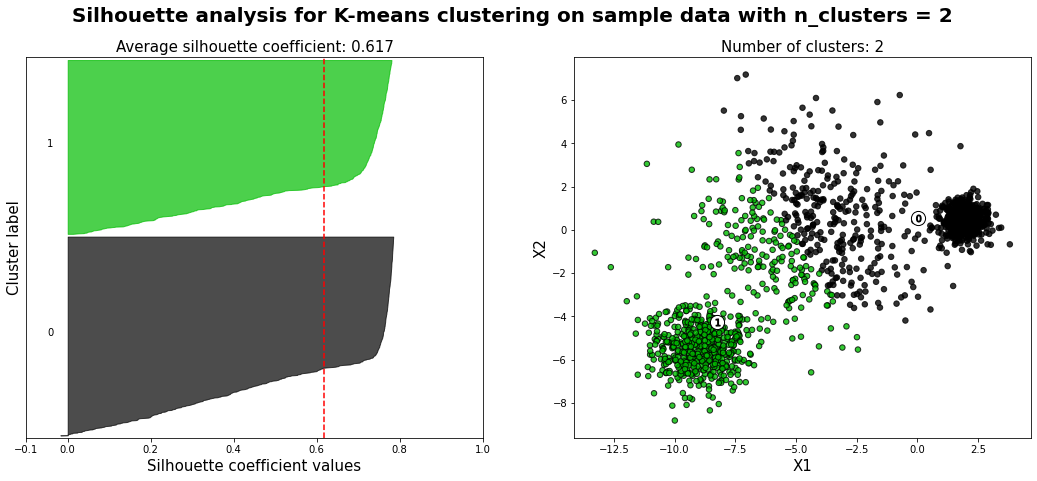

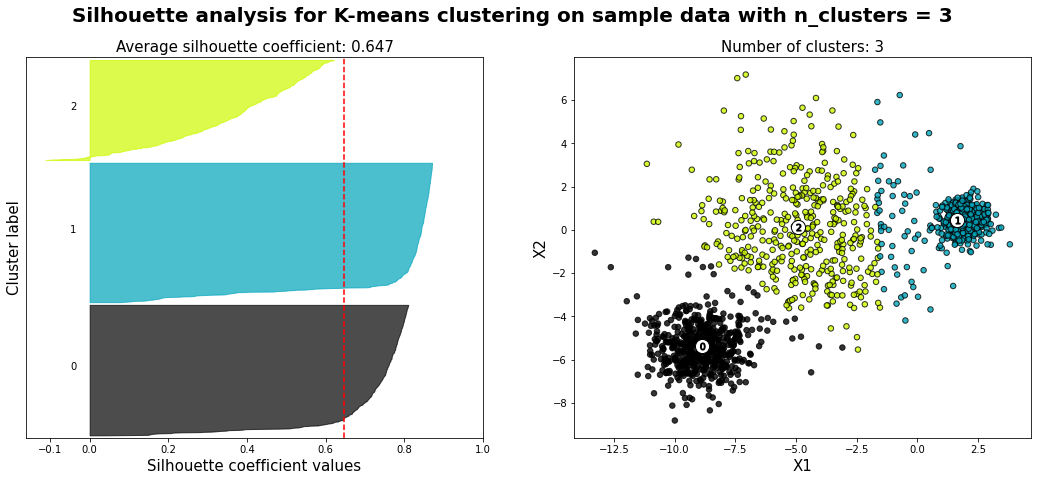

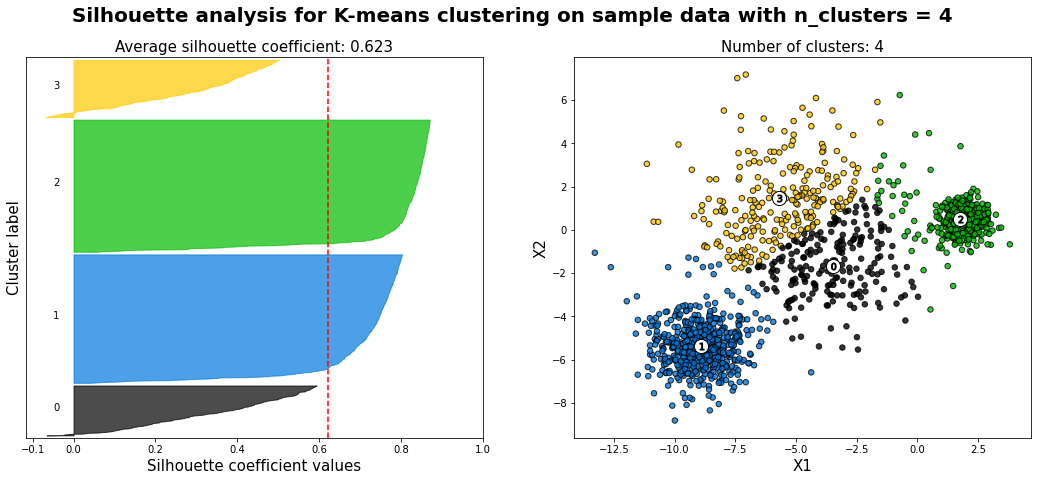

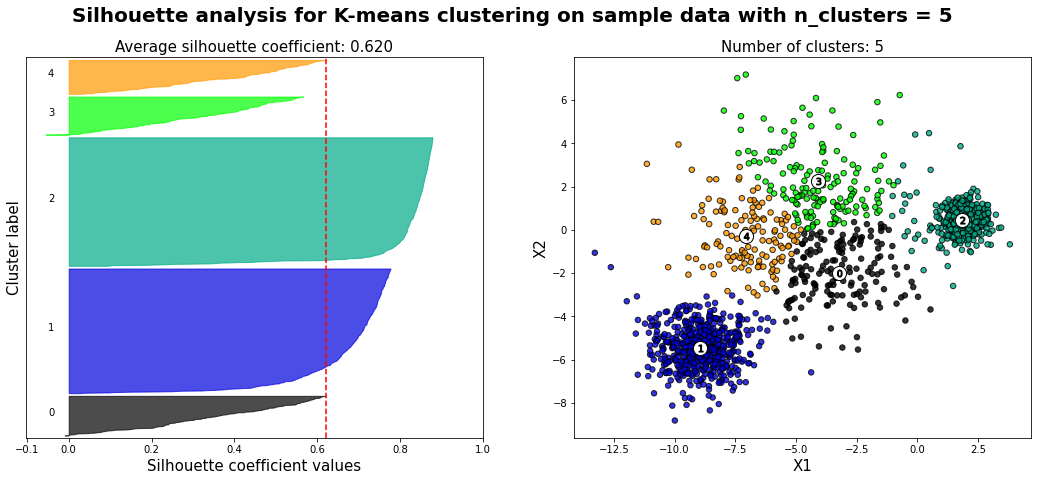

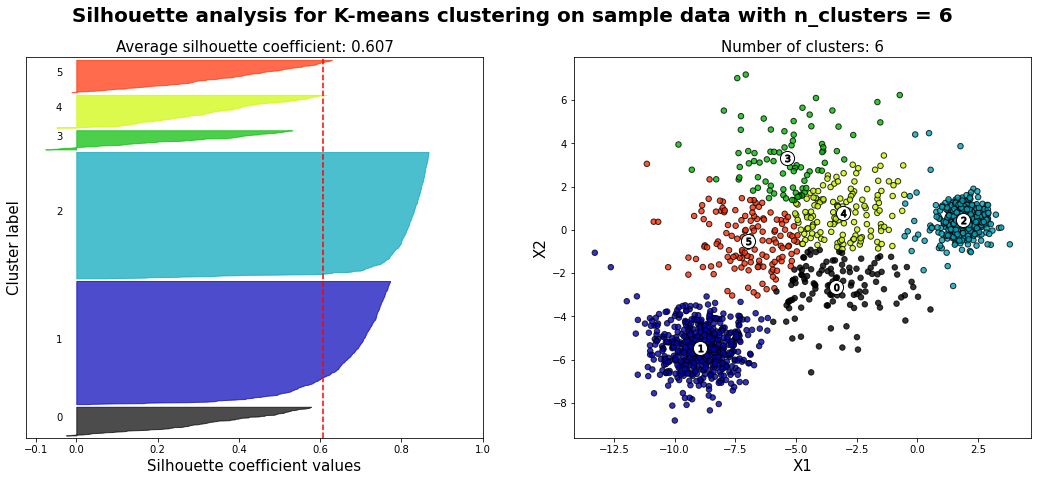

In [185]:
# get input values
X = np.array(df_blobs.loc[:, ["x1", "x2"]])

# one silhouette plot for different numbers of clusters.
for n_clusters in range(2, 7):
    
    # create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # demarcate silhouette plots of individual clusters by inserting blanck space
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # K-means clustering
    kmean = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = kmean.fit_predict(X)

    # compute average silhouette score
    score = silhouette_score(X, cluster_labels)

    # compute silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    # plot silhouette scores for each sample
    y_lower = 10
    for i in range(n_clusters):
        
        # aggregate the silhouette scores for samples belonging to cluster i and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    # axis labels and title
    ax1.set_title("Average silhouette coefficient: {0:0.3f}".format(score), fontsize=15)
    ax1.set_xlabel("Silhouette coefficient values", fontsize=15)
    ax1.set_ylabel("Cluster label", fontsize=15)

    # draw a vertical line for average silhouette score of all the values
    ax1.axvline(x=score, color="red", linestyle="--")

    # clear the yaxis labels / ticks
    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], 
                marker='o', s=30, alpha=0.8, c=colors, edgecolor='k')    
    
    # draw white circles at cluster centers
    centers = kmean.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
        
    # axis labels and title
    ax2.set_title("Number of clusters: {0}".format(n_clusters), fontsize=15)
    ax2.set_xlabel("X1", fontsize=15)
    ax2.set_ylabel("X2", fontsize=15)

    # main title
    plt.suptitle(("Silhouette analysis for K-means clustering on sample data "
                  "with n_clusters = {0}".format(n_clusters)),
                 fontsize=20, fontweight='bold')

plt.show()

**Question :** Quels sont les éléments de ce graphique qui peuvent vous aider à prendre une décision sur un paramètre (ici le nombre de clusters à détecter) ?

**Réponse :** 

## Adjusted Rand Index

L'index ajusté Rand permet de **comparer un résultat de clustering avec les vrais clusters**. Pour chaque paire d'observations nous regardons si elles se situent dans le même cluster ou non, dans le clustering prédit et réel. L'index prend des valeurs entre 0 (clustering aléatoire) et 1 (clustering parfait).

Documentation : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html

**Code :** Calculez l'index ajusté Rand pour un clustering k-means sur les distributions gaussiennes.

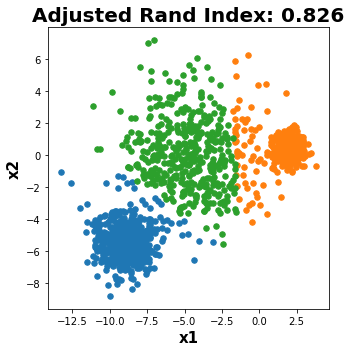

In [186]:
data, label = datasets.make_blobs(n_samples=n_samples, 
                                  cluster_std=[1.0, 2.5, 0.5], 
                                  random_state=random_state)
# clustering
kmean = KMeans(
    n_clusters=3, init='k-means++', 
    n_init=10, max_iter=300, tol=0.0001, 
    verbose=0, random_state=13, 
    algorithm='auto')
kmean.fit(df_blobs.loc[:, ["x1", "x2"]])

# update dataframe clusters
df_blobs.loc[:, "cluster"] = kmean.labels_

# compute Adjusted Rand Index
ari = adjusted_rand_score(label, kmean.predict(X))

# plot
plot_point_clouds(data=df_blobs, 
                  feature_x="x1", 
                  feature_y="x2", 
                  feature_label="cluster",
                  title="Adjusted Rand Index: {0:0.3}".format(ari))

# 3 - Cas pratique (optionnel)

**Code :** Maintenant essayez de maximiser l'index ajusté Rand sur les données réelles de pingouins.

- N'oubliez pas que vous pouvez retirer les valeurs manquantes de votre base de données ou les imputer avec `sklearn.impute.SimpleImputer`.
- Vous pouvez chercher l'ensemble de features le plus pertinent pour clusteriser les espèces de pingouins ou bien conserver l'ensemble des features et les projeter dans un espace de dimension réduit avec `sklearn.decomposition.PCA` (précédé par `sklearn.preprocessing.StandardScaler`).
- Choisissez le bon algorithme de clustering d'après ce que l'on vient de voir sur les données simulées.
- Optimiser les paramètres de cet algorithme en utilisant les coefficients et les graphiques de silhouette.
- Afficher les clusters que vous prédisez pour être sûr de ne pas faire fausse route !